# Layer Cake Example: Regularization Part 2

#### In this example we will see more advanced functionality of the `KirchMig.jl` package, focusing on regularization by cost functions.

### 0. Load modules

In [1]:
using Distributed
addprocs(Sys.CPU_THREADS)

import PyPlot; const plt = PyPlot
import DSP: conv
import Random: seed!, randperm
import Statistics: std
import LinearAlgebra: norm, dot
import Arpack: eigs
using Printf

import KirchMig

### 1. Create reflection data

In [2]:
dz, dx = 15, 15
x = 0:dx:1000; nx = length(x)
z = 0:dz:1000; nz = length(z)

rho = 1000ones(nz, nx)
rho[div(330,dx):end,:] .+= 1000
rho[div(670,dz):end,:] .-= 500

vel = 2000 .+ zero(rho)

imp = 1e-3rho.*vel;

refl = [zeros(nx)'
    (imp[2:end,:] .- imp[1:end-1,:])./(imp[2:end,:] .+ imp[1:end-1,:])]

refl[div(nz, 2)-1, div(nx, 2)] += 0.2
refl[div(nz, 2)+1, div(nx, 2)] += 0.2;

### 2. Create traveltime tables

In [3]:
nr = 46

rec_z = zeros(nr)
rec_x = range(x[1], stop=x[end], length=nr)

ns = 10
seed!(12)
src_z = zeros(ns)
src_x = sort(rec_x[randperm(nr)][1:ns])

trav_r = KirchMig.eikonal_const_vel([rec_z rec_x], z, x, vel[1]);
trav_s = KirchMig.eikonal_const_vel([src_z src_x], z, x, vel[1]);

### 3. Kirchhoff demigration (modeling)

In [4]:
t = 0:0.008:1; nt = length(t)
G = KirchMig.KirchMap(t, trav_r, trav_s)

ricker(t0, f) = @. (1 - 2pi^2 * f^2 * t0^2) * exp(-pi^2 * f^2 * t0^2)
rick_dtt = ricker(t .- t[div(nt,5)], 15);
@views rick_dtt[2:end-1] = (rick_dtt[1:end-2] - 2.0*rick_dtt[2:end-1] + rick_dtt[3:end])/(t[2] - t[1])^2;
rick_dtt /= maximum(abs.(rick_dtt));

W = KirchMig.ConvMap(rick_dtt, nr, ns, nt);

L = W*G;

Once the operator is defined, Kirchhoff modeling is carried out like a simple matrix-vector multiplication. We will add some noise as well, to better assess regularization methods.

In [5]:
@time d = L*refl[:];

seed!(1)
n = randn(size(d))
d += n*std(d)/std(n);

 11.662969 seconds (13.32 M allocations: 706.104 MiB, 3.16% gc time)


### 4. Kirchhoff migration

In [6]:
@time m_mig = L'd;

  2.638741 seconds (2.02 M allocations: 111.658 MiB, 2.03% gc time)


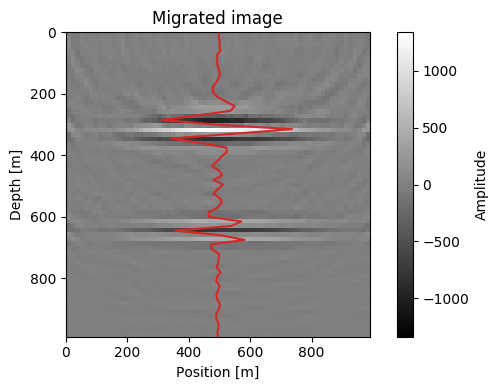

In [7]:
xran = x[end]-x[1]
mod_mig = reshape(m_mig, nz, nx)
vmin, vmax = maximum(abs.(mod_mig))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod_mig[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Migrated image")
fig[:tight_layout]()

### 5. Regularizing with functional constraints

Previously we regularized with a simple constraint, that is our solution was the minimizer of

$$J_\Gamma(m) = \|Lm - d\|^2 + \mu \|\Gamma m\|^2$$

where $\Gamma$ is a regularizing matrix. In this case, minimizer is found analytically by


$$ m_\Gamma = (L^\dagger L + \Gamma^\dagger \Gamma)^{-1} L^\dagger d, $$

which we obtained by solving the following system approximately.

$$ (L^\dagger L + \Gamma^\dagger \Gamma)m = L^\dagger d.$$




Sometimes we would like to introduce constraints which cannot be so simply. In the general case, we would like a solution which minimizes the general equation

$$J_f(m) = \|Lm - d\|^2 + f(m).$$

Generally, $f(m)$ is nonlinear and there is no closed-form solution to this problem. We are able to solve it using large-scale nonlinear optimization methods, such as can be found in `Optim.jl` for example. In the following example, we will see how to do this for a specific $f(m)$.

#### Using `Optim.jl`

`Optim.jl` is a package for ["optimizing functions of various kinds"](http://julianlsolvers.github.io/Optim.jl/latest/). It provides a simple(-ish) interface to general unconstrained optimization such as the one we are attempting to perform. In order to understand the library, we will first try to optimize $J_0$, that is, the unregularized problem.

Its [documentation](http://julianlsolvers.github.io/Optim.jl/latest/user/minimization/) is fairly straightforward, but some caveats are in order for large-scale optimization such as ours. Generally, a function `f` can be optimized  with

```julia
optimize(f, g!, h!, x0, method, options)
```
where `g!` is the gradient of `f`, and `h!` is the Hessian of `f`. While both the Hessian and gradient can be omitted from the function call, omitting the gradient is severely detrimental to performance. Another important aspect to note is that the gradient is mutating, meaning that it alters the first argument. Indeed, the its first argument is deemed the `storage` variable, where the gradient will be stored, and the second argument is where the gradient should be evaluated.

In our case, $J_0(m) = \|Lm - d\|^2$, meaning that ([Petersen and Pedersen, 2012](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf)):

$$\nabla J_0 =\nabla (d-Lm)^\dagger(Lm - d) = 2L^\dagger(Lm-b)$$

In [8]:
J0(m) = norm(L*m - d)^2

function ∇J0!(storage, m)
    storage[1:end] = 2L'L*m - 2m_mig
end

∇J0! (generic function with 1 method)

Before we call `optimize`, we must ensure that our gradient is correct. To do that, make sure that

$$\frac{J(u + hv) - J(u - hv)}{2h} \approx \nabla J(u) \cdot v$$

where $h\in\mathbb{R}$ and $u, v \in \mathbb{R}^{n_z n_x}$.

In [9]:
seed!(123);

nL = size(L, 2)
u = randn(nL)
v = randn(nL)
h = 0.001*maximum(abs.(u))

storage = zero(u)
∇J0!(storage, u)

g1 = (J0(u + h*v) - J0(u - h*v))/2h
g2 = dot(storage, v)
err = 100abs(g1 - g2)/((g1+g2)/2)
println("$(@sprintf("%.2f", err))% error")

0.00% error


Now that we have ensured correctness of the gradient, can minimize the function.

In [10]:
import Optim

In [11]:
@time res = Optim.optimize(J0, ∇J0!, zeros(size(L, 2)),
                           Optim.ConjugateGradient(),
                           Optim.Options(iterations = 20, show_trace=true))

Iter     Function value   Gradient norm 
     0     3.545850e+04     2.677903e+03
     1     2.280171e+04     8.511535e+02
     2     2.050123e+04     7.879526e+02
     3     1.975588e+04     3.952846e+02
     4     1.883315e+04     2.937021e+02
     5     1.834065e+04     2.437563e+02
     6     1.801594e+04     1.859136e+02
     7     1.781622e+04     1.910541e+02
     8     1.761568e+04     1.446368e+02
     9     1.745191e+04     1.101923e+02
    10     1.731227e+04     1.225773e+02
    11     1.719758e+04     1.066231e+02
    12     1.709526e+04     8.126566e+01
    13     1.701031e+04     7.053825e+01
    14     1.694760e+04     8.784361e+01
    15     1.689569e+04     9.522393e+01
    16     1.685195e+04     6.179864e+01
    17     1.681055e+04     5.318005e+01
    18     1.677699e+04     5.793124e+01
    19     1.676461e+04     9.462035e+01
    20     1.674462e+04     6.455214e+01
 18.784696 seconds (11.95 M allocations: 1.609 GiB, 2.50% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [0.00891302811467406,0.0075358830381753485, ...]
 * Minimum: 1.674462e+04
 * Iterations: 20
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 8.02e-03 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.19e-03 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.46e+01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 41
 * Gradient Calls: 22

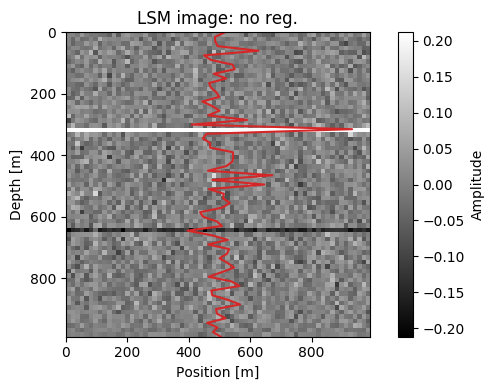

In [12]:
pclip=0.5
xran = x[end]-x[1]
mod_lsm_0 = reshape(res.minimizer, nz, nx)
vmin, vmax = pclip*maximum(abs.(mod_lsm_0))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod_lsm_0, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod_lsm_0[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="LSM image: no reg.")
fig[:tight_layout]()

#### Total variation regularization

A common approach to noisy inversion is to use [total variation regularization](https://en.wikipedia.org/wiki/Total_variation_denoising). In this method, the cost function can be written as

$$J_\text{TV} (m) = \|Lm - d\|^2 + \mu TV(m)$$

where

$$TV(m) = \sum_i |(\nabla m)_i|,$$

where $\nabla m = (\partial_x m_i, \partial_z m_i)$ in the 2D case. $TV(m)$ is the sum of vector norms of the gradients at each model location. The minimum variation solution is given by

$$m_\text{TV} = \text{arg} \min_m J_\text{TV}(m)$$

Now that we have the cost function fixed, we must compute the gradient. The gradient of the least-squares part has already been computed, so we need to compute the gradient of the TV. This gradient is well known ([Rudin et al., 1992](https://www.sciencedirect.com/science/article/pii/016727899290242F?via%3Dihub)), but it can be computed discretely in the following manner. First, let's write the discretized version of the $TV$ norm:

$$TV(m_i) = \sum_i \sqrt{(D^x m)_i^2 + (D^z m)_i^2}$$

$$TV(m_i) = \sum_i \sqrt{\left(\sum_kD^x_{ik} m_k\right)^2 + \left(\sum_k D^z_{ik} m_k\right)^2}$$

where $D^{x/z}$ are horizontal and vertical derivative linear operators (e.g. forward finite differences). Then,


$$\partial_j TV(m_i) = \sum_i \frac{\partial_j \left(\left(\sum_kD^x_{ik} m_k\right)^2
                               + \left(\sum_k D^z_{ik} m_k\right)^2\right)}
                            {2\sqrt{\left(\sum_kD^x_{ik} m_k\right)^2 +
                                   \left(\sum_k D^z_{ik} m_k\right)^2}}$$

$$\partial_j TV(m_i) = \sum_i \frac{  \left(\sum_kD^x_{ik} m_k\right)\partial_j \left(\sum_kD^x_{ik} m_k\right)
                             + \left(\sum_kD^z_{ik} m_k\right)\partial_j \left(\sum_kD^z_{ik} m_k\right)
                            }{\sqrt{\left(\sum_kD^x_{ik} m_k\right)^2 +
                               \left(\sum_k D^z_{ik} m_k\right)^2}
                           }$$
                                   
$$\partial_j TV(m_i) = \sum_i \frac{  \left(\sum_kD^x_{ik} m_k\right)\left(\sum_kD^x_{ik} \delta_{jk}\right)
                             + \left(\sum_kD^z_{ik} m_k\right)\left(\sum_kD^z_{ik} \delta_{jk}\right)
                            }{ \sqrt{\left(\sum_kD^x_{ik} m_k\right)^2 +
                               \left(\sum_k D^z_{ik} m_k\right)^2}
                           }$$                                  
$$\partial_j TV(m_i) = \sum_i \frac{  \left(\sum_kD^x_{ik} m_k\right)D^x_{ij}
                             + \left(\sum_kD^z_{ik} m_k\right)D^z_{ij}
                            }{ \sqrt{\left(\sum_kD^x_{ik} m_k\right)^2 +
                               \left(\sum_k D^z_{ik} m_k\right)^2}
                           }$$
since $\partial_jm_k = \delta_{jk}$ where $\delta_{jk}$ is the Kronecker delta. We note that $D_{ij}^{x/z} = - D_{ji}^{x/z}$ when using central finite differences, and so

$$\partial_j TV(m_i) = \sum_i -D^x_{ji} \frac{(D^x m)_i}{ \sqrt{(D^x m)_i^2 + (D^z m)_i^2}}
                       -D^z_{ji} \frac{(D^z m)_i}{ \sqrt{(D^x m)_i^2 + (D^z m)_i^2}}.$$
                       
with some abuse in notation, we obtain

$$\partial_j TV(m_i) = \sum_i -(D^x_{ji}, D^z_{ji}) \cdot  \frac{((D^x m)_i, (D^z m)_i)}{\sqrt{(D^x m)_i^2 + (D^z m)_i^2}}$$


$$\nabla  TV(m) = -(D^x, D^z) \cdot  \frac{(D^x, D^z)m}{|(D^x, D^z)m|}$$

This is indeed equivalent to the [Fréchet derivative of the continuous functional](https://mathoverflow.net/questions/151540/fr%C3%A9chet-derivative-of-the-total-variation-norm)
$$TV(m) = -\nabla \cdot\left(\frac{\nabla m}{|\nabla m|}\right)$$

We see that if the model is locally zero, the gradient becomes undefined. A good approach is to modify the defition of $TV$ for the following

$$TV(m) = \sum_i \sqrt{|\nabla m_i|^2 + \varepsilon^2} ,$$

in this case, the gradient becomes

$$\nabla TV(m) = -\nabla \cdot\left(\frac{\nabla m}{\sqrt{|\nabla m|^2 + \varepsilon^2}}\right).$$


Finally, before we compute gradients, we will set $\mu = 0.005\lambda$ where $\lambda$ is the largest singular value of $L$.

In [13]:
@time λ, ϕ = eigs(L'L; nev=1, maxiter=2); λ = λ[1]

 13.706819 seconds (10.93 M allocations: 1.225 GiB, 4.07% gc time)


49811.11531538278

In [14]:
function TV(x)
    grad = KirchMig.gradient(x, nz, nx) # Returns a nz × nx × 2 array in 2D
    norm_grad = sqrt.(sum(grad.^2, dims=3))
    e = maximum([100eps(), 0.01maximum(norm_grad)])
    return 0.002*λ*sum(sqrt.(norm_grad.^2 .+ e^2))
end
function ∇TV!(storage, x)
    grad = KirchMig.gradient(x, nz, nx)
    norm_grad = sqrt.(sum(grad.^2, dims=3))
    e = maximum([100eps(), 0.01maximum(norm_grad)])
    grad ./= sqrt.(norm_grad.^2 .+ e^2)
    
    storage[1:end] = -0.002*λ*KirchMig.divergence(grad[:], nz, nx)[:]
end

∇TV! (generic function with 1 method)

In [15]:
seed!(123);

nL = size(L, 2)
u = randn(nL)
v = randn(nL)
h = 0.001*maximum(abs.(u))

storage = zero(u)
∇TV!(storage, u)

g1 = (TV(u + h*v) - TV(u - h*v))/2h
g2 = dot(storage, v)
err = 100abs(g1 - g2)/((g1+g2)/2)
println("$(@sprintf("%.2f", err))% error")

6.91% error


The error is not excellent but we can live with that; it will not overly hamper our inversion. We can now define the full cost function:

In [16]:
JTV(x) = J0(x) + TV(x)

function ∇JTV!(storage, x)
    ∇J0!(storage, x)
    s = storage[:]
    ∇TV!(storage, x)
    storage[1:end] = s + storage[1:end]
end

# Check gradient
seed!(123);

nL = size(L, 2)
u = randn(nL)
v = randn(nL)
h = 0.001*maximum(abs.(u))

storage = zero(u)
∇JTV!(storage, u)

g1 = (JTV(u + h*v) - JTV(u - h*v))/2h
g2 = dot(storage, v)
err = 100abs(g1 - g2)/((g1+g2)/2)
println("$(@sprintf("%.2f", err))% error")

0.06% error


In [17]:
@time res_tv = Optim.optimize(JTV, ∇JTV!, zeros(size(L, 2)),
                              Optim.ConjugateGradient(),
                              Optim.Options(iterations = 20, show_trace=true))

Iter     Function value   Gradient norm 
     0     3.545850e+04     2.677903e+03
     1     2.630495e+04     7.400765e+02
     2     2.437448e+04     6.228432e+02
     3     2.361613e+04     4.197788e+02
     4     2.311971e+04     2.996719e+02
     5     2.274913e+04     2.298415e+02
     6     2.249306e+04     2.309231e+02
     7     2.228911e+04     1.830146e+02
     8     2.214546e+04     1.473903e+02
     9     2.203918e+04     1.554623e+02
    10     2.195267e+04     1.620098e+02
    11     2.187603e+04     1.329810e+02
    12     2.179921e+04     1.206600e+02
    13     2.171895e+04     1.327988e+02
    14     2.165929e+04     1.792505e+02
    15     2.159874e+04     1.391953e+02
    16     2.155920e+04     1.089221e+02
    17     2.152553e+04     1.164285e+02
    18     2.149432e+04     1.008997e+02
    19     2.147380e+04     1.071254e+02
    20     2.145973e+04     9.799780e+01
 10.524718 seconds (5.69 M allocations: 1.374 GiB, 2.96% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [0.004925965259873769,0.0011716272133723575, ...]
 * Minimum: 2.145973e+04
 * Iterations: 20
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 5.55e-03 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 6.56e-04 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 9.80e+01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 41
 * Gradient Calls: 22

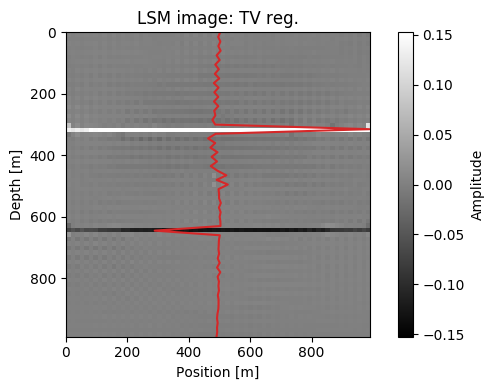

In [18]:
pclip=0.5
xran = x[end]-x[1]
mod_lsm_tv = reshape(res_tv.minimizer, nz, nx)
vmin, vmax = pclip*maximum(abs.(mod_lsm_tv))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax[:imshow](mod_lsm_tv, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig[:colorbar](cax, ax=ax)
cbar[:ax][:set](ylabel="Amplitude");
ax[:plot](xran*mod_lsm_tv[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax[:set](xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="LSM image: TV reg.")
fig[:tight_layout]()